# Voici notre notebook pour le projet explain 


## equipe 25

On commence par faire les imports 

In [1]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import ast
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from lime.lime_text import LimeTextExplainer
import ipywidgets as widgets
from IPython.display import display
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yilmaz-a/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yilmaz-a/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yilmaz-a/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yilmaz-a/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

---

## Voici le code avec lequel nous avons créé notre fichier contenant les données lemanisées

On commence par importer les données et supprimer les balises html

On applique la fonction créée plus tôt

On supprime les anciennes colonnes obsolètes

On crée la fonction qui va lemaniser les textes afin de pouvoir les traiter par la suite 

On applique la fonction à la colonne clean_claim_lem qui est la seule que l'on va utiliser dans la suite du code

Nous avons stocké la df résultante de ce code dans un fichier afin de ne pas perdre de temps à relancer le code a chaque fois que nous aurons besoin de faire des tests. Nous avons stocké les données dans le fichier "tst.csv"

---

## chargement du fichier


Nous allons donc maintenant arriver dans le code qui permet de créer le modèle et pour cela nous commençons par charger le fichier qui a été crée grâce au code au ci-dessus

 On charge les données et ne gardons que les colonnes qui nous intéresse 

In [2]:
df = pd.read_csv("tst.csv")
df = df[['clean_claim_lem', 'CPC']]

Ensuite nous avons créé une fonction qui permet de convertir la colonne CPC en liste car elle est lue en temps que str

In [3]:
def convert_to_list(cpc_value):
    try:
        return ast.literal_eval(cpc_value)
    except (ValueError, SyntaxError):
        return cpc_value

Nous appliquons la fonction et supprimons les doublons en passsant par un set 

In [4]:
df.loc[:, 'CPC'] = df['CPC'].apply(convert_to_list)
df['CPC'] = df['CPC'].apply(lambda x: list(set(x)))

Nous créons ensuite les colonnes labels et sub_catégories qui vont respectivement contenir la catégorie principale et la première sous-catégorie du classement CPC 

In [5]:
df['labels'] = df['CPC'].apply(lambda x: list(set(item[0] for item in x)))
df['sub_categories'] = df['CPC'].apply(lambda x: list(set(item[:3] for item in x)))

In [6]:
df = df.rename(columns={'clean_claim_lem': 'text'})


---

---

---

### Afin de visualiser les données nous allons effectuer les plots d'élements de chaque catégorie et sous-catégorie  

In [7]:
label_counts = df['labels'].apply(pd.Series).stack().value_counts()
sub_category_counts = df['sub_categories'].apply(pd.Series).stack().value_counts()

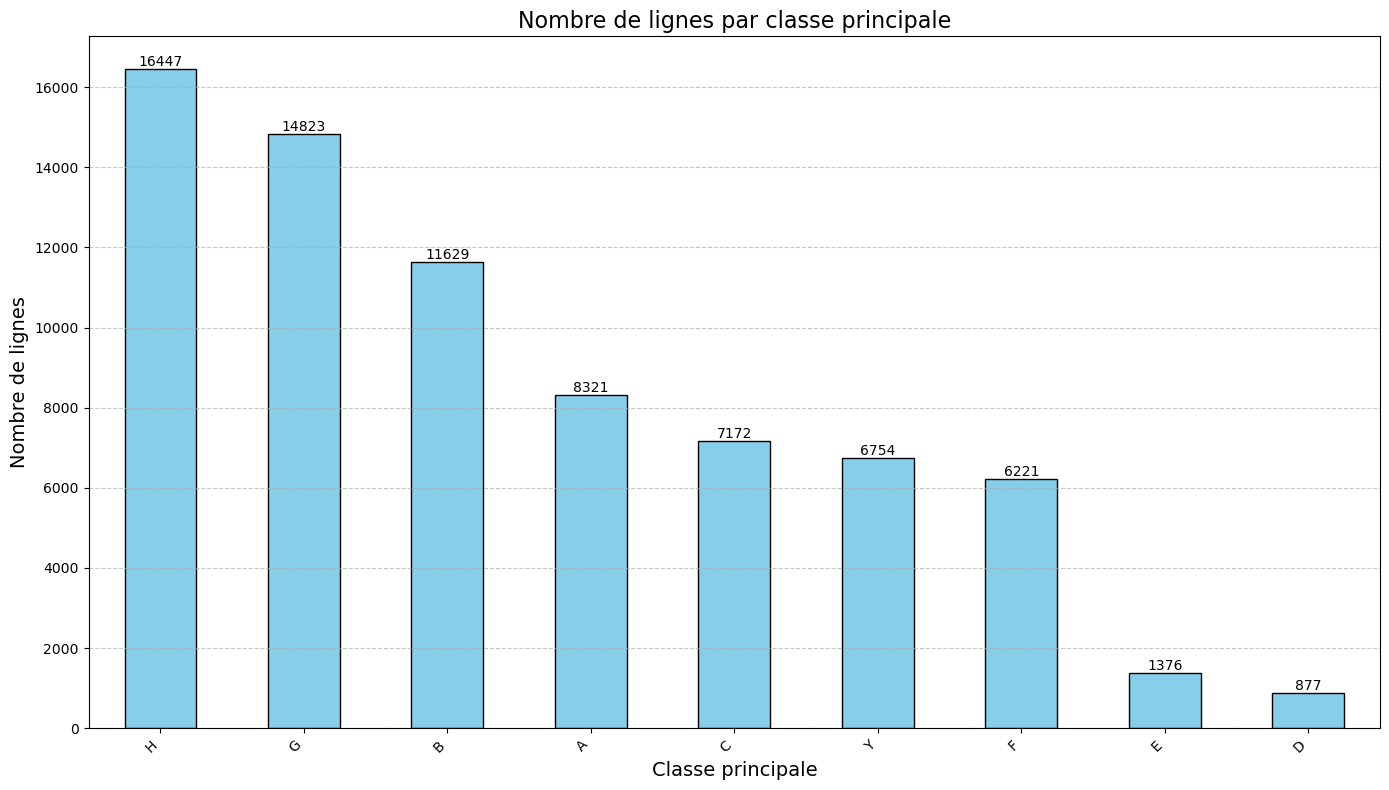

In [8]:
plt.figure(figsize=(14, 8))  # Taille de la figure
bars = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')  # Plot des barres
plt.title('Nombre de lignes par classe principale', fontsize=16)  # Titre
plt.xlabel('Classe principale', fontsize=14)  # Étiquette axe des x
plt.ylabel('Nombre de lignes', fontsize=14)  # Étiquette axe des y
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes axe des x
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille

# Ajout des annotations (valeurs au-dessus des barres)
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'), 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 5), 
                 textcoords='offset points')

plt.tight_layout()  # Ajustement automatique des marges
plt.show()

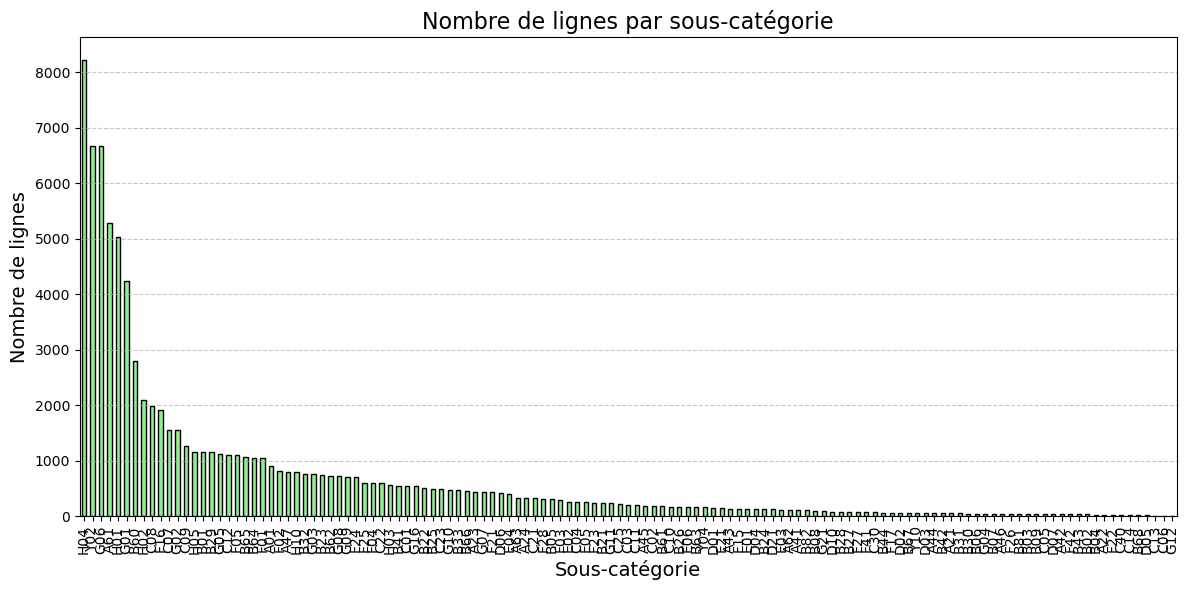

In [9]:
sub_category_counts = df['sub_categories'].apply(pd.Series).stack().value_counts()
plt.figure(figsize=(12, 6))
bars = sub_category_counts.plot(kind='bar', color='lightgreen', edgecolor='black')  
plt.title('Nombre de lignes par sous-catégorie', fontsize=16)  
plt.xlabel('Sous-catégorie', fontsize=14) 
plt.ylabel('Nombre de lignes', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 



plt.tight_layout()
plt.show()

Nous obervons que la df contient énormement de catégories et sous-catégories qui sont très et trop sous-représentées

Afin d'avoir un modele pouvant être entraîné correctement nous allons supprimer toutes les sous-catégories qui n'ont pas un minimum de 1500 lignes 

Cette manière de fonctionner va nous permettre de ne garder que les classes sur lesquels le modèle pourra s'entrainer efficacement 

On commence par selectionner les catégories valides

In [10]:
min_label_samples = 1500
valid_labels = label_counts[label_counts >= min_label_samples].index.tolist()


On ne garde que les catégories valides et supprimons les lignes qui n'ont plus de catégorie

In [11]:
df['labels'] = df['labels'].apply(lambda labels: [label for label in labels if label in valid_labels])
df = df[df['labels'].map(len) > 0]



On filtre les-sous catégorie en fonctions des catégories principales, on applique aussi le filtre des 400 sur les sous-catégories

In [12]:
sub_category_counts = df['sub_categories'].apply(pd.Series).stack().value_counts()
min_sub_category_samples = 500
valid_sub_categories = sub_category_counts[sub_category_counts >= min_sub_category_samples].index.tolist()



On garde les sous-catégories valident et on supprime les lignes n'ayant plus de sous-catégorie 

In [13]:
df['sub_categories'] = df['sub_categories'].apply(lambda sub_cats: [sub_cat for sub_cat in sub_cats if sub_cat in valid_sub_categories])
df = df[df['sub_categories'].map(len) > 0]

On peut maintenant recompter les catégories pour les prochains plots

In [14]:
label_counts = df['labels'].apply(pd.Series).stack().value_counts()
sub_category_counts = df['sub_categories'].apply(pd.Series).stack().value_counts()

---

On peut maintenant réafficher les plots avec les catégories que nous allons utiliser 

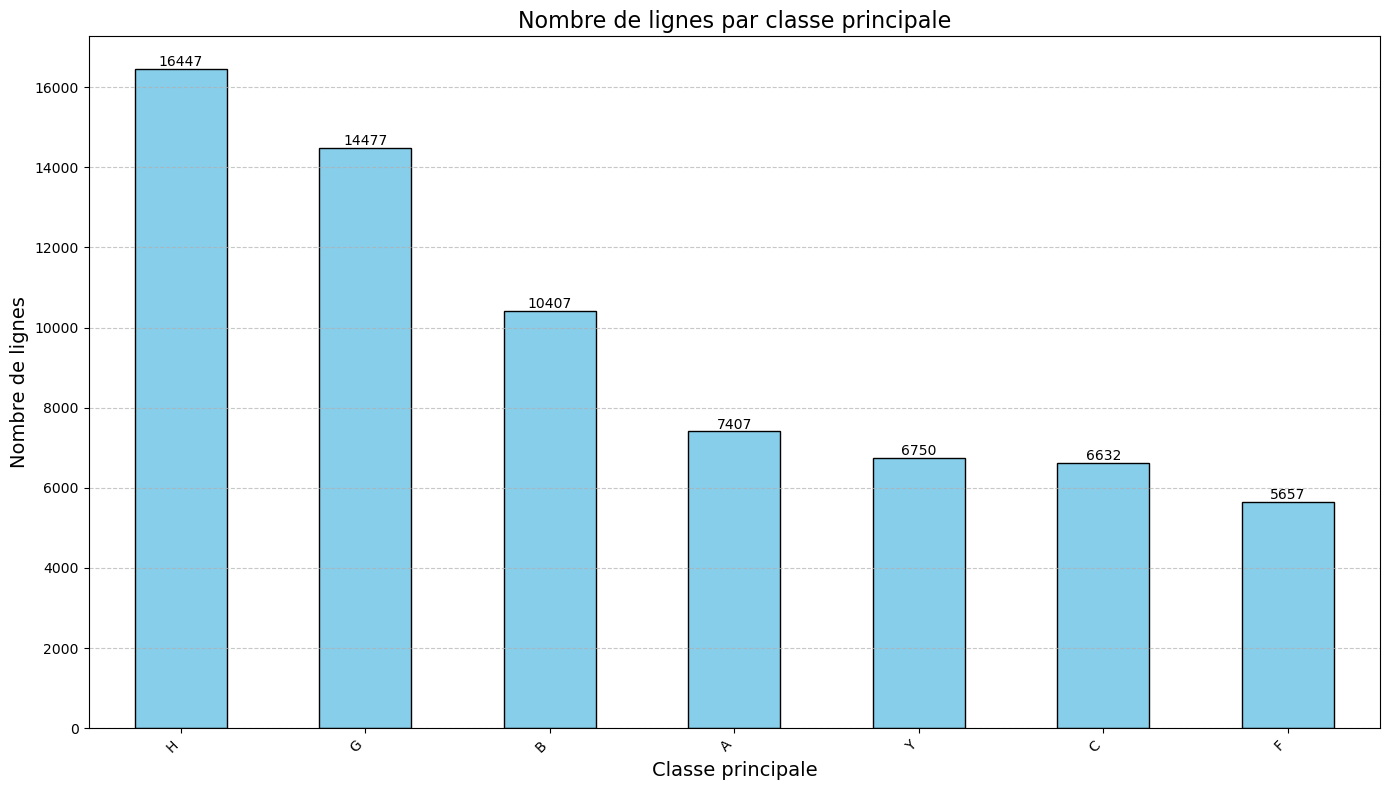

In [15]:


plt.figure(figsize=(14, 8))  # Taille de la figure
bars = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')  # Plot des barres
plt.title('Nombre de lignes par classe principale', fontsize=16)  # Titre
plt.xlabel('Classe principale', fontsize=14)  # Étiquette axe des x
plt.ylabel('Nombre de lignes', fontsize=14)  # Étiquette axe des y
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes axe des x
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille

# Ajout des annotations (valeurs au-dessus des barres)
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'), 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 5), 
                 textcoords='offset points')

plt.tight_layout()  # Ajustement automatique des marges
plt.show()


On continue avec les sous-catégories

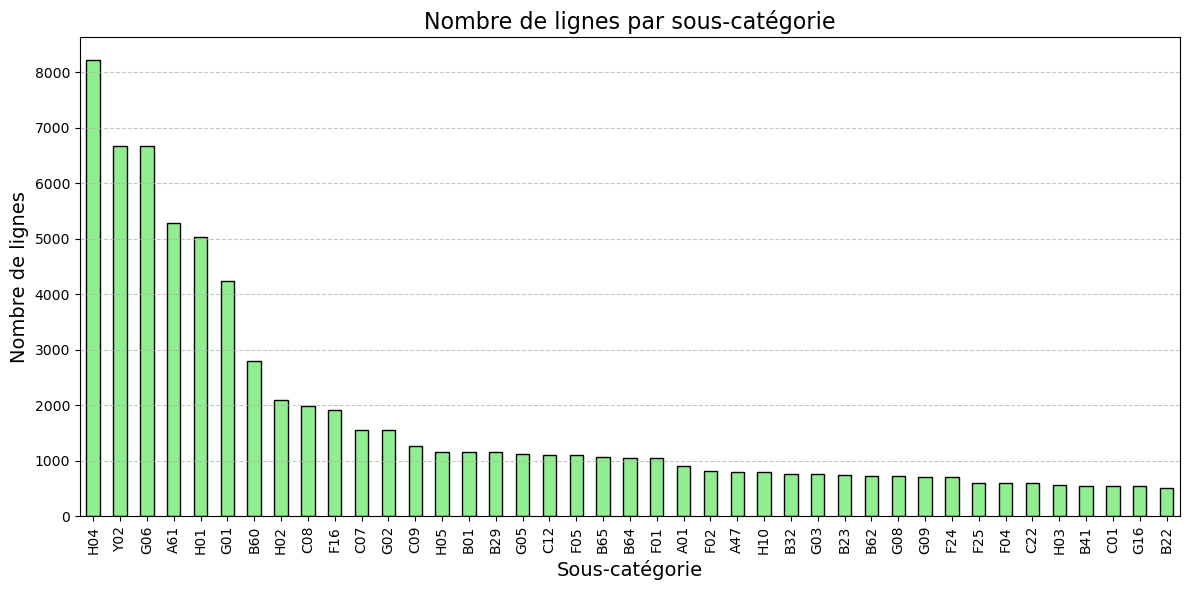

In [16]:



plt.figure(figsize=(12, 6))  # Taille de la figure
bars = sub_category_counts.plot(kind='bar', color='lightgreen', edgecolor='black')  # Plot des barres
plt.title('Nombre de lignes par sous-catégorie', fontsize=16)  # Titre
plt.xlabel('Sous-catégorie', fontsize=14)  # Étiquette axe des x
plt.ylabel('Nombre de lignes', fontsize=14)  # Étiquette axe des y
plt.xticks(rotation=90)  # Rotation des étiquettes axe des x
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille



plt.tight_layout()  # Ajustement automatique des marges
plt.show()


Le problème de sous-représentation de certaines catégories et sous-catégories est maintenant réglé 

---

---

---

### Tokenisation, binarization et division des données

La base de données étant maintenant complète, nous pouvons reset l'index

In [17]:
df.reset_index(drop=True, inplace=True)

Nous trouvons ensuite les ensembles finaux de catégories et de sous-catégories

In [18]:
all_main_labels = list(set(label for labels in df['labels'] for label in labels))
all_sub_categories = list(set(sub for subs in df['sub_categories'] for sub in subs))


In [19]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
num_words_in_sequences = [len(seq) for seq in sequences]
average_words_per_sequence = np.mean(num_words_in_sequences)
print(average_words_per_sequence)
X_data = pad_sequences(sequences, maxlen=300)

549.0755856073412


---

Cette partie permet de binarizer les catégories et sous-catégories. y_data est une matrice où chaque ligne représente un texte et où chaque colonne représente une catégorie. Une case est à 1 si le texte est de cette catégorie, sinon la case est à 0 

In [20]:
mlb = MultiLabelBinarizer(classes=all_main_labels)
y_data_main = mlb.fit_transform(df['labels'])

mlb_sub = MultiLabelBinarizer(classes=all_sub_categories)
y_data_sub = mlb_sub.fit_transform(df['sub_categories'])

---

Nous pouvons maintenant diviser les donner en ensemble de train et de test. Nous attribuons chaque ligne de manière random a une des deux catégories avec un ratio de 80-20 avec 80 pour les données d'entraînement

In [21]:
X_train, X_test, y_train_main, y_test_main, y_train_sub, y_test_sub = train_test_split(X_data, y_data_main, y_data_sub, test_size=0.2, random_state=42)


---

---

---

### embedding GloVe 

La création de la matrice d'embedding est une étape cruciale de notre projet car elle va nous permettre d'avoir une représentation des mots et des liens entre ceux très complexes. 

Elle permet de rapprocher des mots vis-a-vis d'un certain nombre de vecteur ( 200 dans notre cas ) 

Cette première partie rassemble les mots avec leurs vecteur a partir du fichier télécharger glove.6B.200d.txt

In [22]:
embedding_dim = 200
embedding_path = 'glove.6B.200d.txt'  

embeddings_index = {}
with open(embedding_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

La seconde partie utilise le dictionnaire crée dans la première afin de créer une matrice contenant les vecteurs de chaque mot ( dans la limite des 20 000 plus courant donnés par le tokenizer )

In [23]:
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


---

---

---

## Définition du modèle  

Nous avons d'abord choisi d'utiliser le CNN car c'est un model disposant de bonne performance et est très documenté. 

Ce modèle étant notre première expérience en NN nous avons préferé ne predire que la catégorie principale. 

Ce premier modèle est composé de plusieurs type de couche différentes : 

Tout d'abord les embbeding layer qui convertissent les tokens en vecteur ce qui permet de capturer une certaine relation sémantique entre les mots 

Ensuite, les Conv1D qui applique les opérations de convolution détectant les motifs dans le texte 

Ensuite la MaxPooling1D réduit les dimensions des caractéristiques trouvées par la convolution. Cela permet de garder un maximum d'informations tout en réduisant le nombre de paramètres du modèle 

Ensuite, la GlobalMaxPooling1D fait la même chose que la précèdente mais de manière plus extrême

Pour finir, Dense qui interpète les paramètres triés par les couches precedentes et qui permettent d'apprendre les relations complexes entre les mots 

In [24]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=embedding_dim, input_length=300, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(7, activation='sigmoid'))  # Utilisation de 'sigmoid' pour la classification multi-étiquettes


/Users/yilmaz-a/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train_main, epochs=8, batch_size=32, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test_main)
print(f"Loss: {loss}, Accuracy: {accuracy}")
print(f"Classes: {mlb.classes}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,000,000 (15.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,000,000 (15.26 MB)

Epoch 1/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.2113 - loss: 0.5620 - val_accuracy: 0.2426 - val_loss: 0.4567
Epoch 2/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.2619 - loss: 0.4436 - val_accuracy: 0.2765 - val_loss: 0.4419
Epoch 3/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.2900 - loss: 0.4264 - val_accuracy: 0.3024 - val_loss: 0.4306
Epoch 4/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.3102 - loss: 0.4115 - val_accuracy: 0.3702 - val_loss: 0.4268
Epoch 5/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.3954 - loss: 0.4033 - val_accuracy: 0.3655 - val_loss: 0.4310
Epoch 6/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.4132 - loss: 0.3931 - val_accuracy: 0.3760 - val_loss: 0.4304
Epoch 7/8
911/911 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.4232 - loss: 0.3914 - val_accuracy: 0.3857 - val_loss: 0.4291
Epoch 8/8
217/911 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.4228 - loss: 0.3857

Calcul du F1 score

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
f1_micro = f1_score(y_test_main, y_pred_binary, average='micro')
print(f"F1 Score (micro): {f1_micro}")

Le modèle a un résultat correcte mais toujours insuffisant, nous avons donc ajouté des couches de BI-LSTM dans notre modèle final afin de mieux lier les mots entre eux. 

---

### Notre modèle final

Mais avant cela il est important d'expliquer que le modèle prédit 2 résultats à la fois. Pour réaliser cela, le modèle se scinde en 2 afin de prédire d'un côté les catégories principales et de l'autres les sous-catégories. Malgré que la branche des catégories principales peut paraître inutile car elle est comprise dans les sous-catégories nous l'avons gardée comme ça, car elle nous donne énormément d'inforamtions sur précision du modèle et la perte de celle-ci quand on passe à une prédiction avec beaucoup plus de catégories.

Nous allons voir comment les couches dont nous n'avons pas parler plus haut, notament BI-LSTM et dropout

La couche BI-LSTM permet de traiter les dépendances à long terme et ajoute donc un véritable plus à notre modèle 

Les couches dropout desactivent des neurones afin d'éviter le surentraînement 

In [ ]:
input_layer = Input(shape=(300,))
embedding_layer = Embedding(input_dim=20000, output_dim=200, input_length=300, trainable=True)(input_layer)
conv1d_layer1 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
maxpooling_layer1 = MaxPooling1D(pool_size=2)(conv1d_layer1)
conv1d_layer2 = Conv1D(filters=128, kernel_size=5, activation='relu')(maxpooling_layer1)
maxpooling_layer2 = MaxPooling1D(pool_size=2)(conv1d_layer2)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(maxpooling_layer2)
globalmaxpooling_layer = GlobalMaxPooling1D()(lstm_layer)

Une fois que le "tronc" du modèle est là nous pouvons passer au deux branches pour les catégories et sous-catégories 

Avant toutes les catégories :

In [ ]:
dense_layer_main = Dense(128, activation='relu')(globalmaxpooling_layer)
dropout_layer_main = Dropout(0.3)(dense_layer_main)
output_layer_main = Dense(len(all_main_labels), activation='sigmoid', name='main_output')(dropout_layer_main)

Ensuite les sous-catégories :

In [ ]:
dense_layer_sub = Dense(128, activation='relu')(globalmaxpooling_layer)
dropout_layer_sub = Dropout(0.3)(dense_layer_sub)
output_layer_sub = Dense(len(all_sub_categories), activation='sigmoid', name='sub_output')(dropout_layer_sub)


---

Nous allons maintenant définir et compiler notre modèle : 

In [ ]:
model = Model(inputs=input_layer, outputs=[output_layer_main, output_layer_sub])


Compilation : 

In [ ]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss={'main_output': 'binary_crossentropy', 'sub_output': 'binary_crossentropy'}, metrics=['accuracy'])


--- 

---

---

## Entraînement et performance

Afin de trouver les meilleurs paramètres pour notre modèle, nous avons créer une fonction qui va tester un certain nombre de ceux-ci et garder le meilleur. 

Cette fonction teste 144 possibilités et a run pendant plus de 32h pour nous donner le résultat suivant :
Best Parameters: {'max_len': 150, 'lstm_units': 128, 'dropout_rate': 0.3, 'epochs': 10, 'batch_size': 64, 'filters': 128}

---

Nous pouvons maintenant passer à l'entraînement du modèle grâce aux hyperparamètres trouver par notre fonction

In [ ]:
model.fit(X_train, {'main_output': y_train_main, 'sub_output': y_train_sub}, epochs=10, batch_size=64, validation_split=0.2)


---


---

---

## Evaluation du modèle 

On teste le modèle sur la variable de test 

In [ ]:

y_pred_main, y_pred_sub = model.predict(X_test)

On binarise les résultats. La valeur de chaque colonne correspond à l'appartenance ou non à une catégorie et la valeur est comprise entre 0 et 1. On met le seuil a 0.5 -> si la valeur est 

In [ ]:

y_pred_main_binary = (y_pred_main > 0.3).astype(int)
y_pred_sub_binary = (y_pred_sub > 0.3).astype(int)

On calcule la précision, le recall et le F1 pour les catégories principales 

In [ ]:

precision_main = precision_score(y_test_main, y_pred_main_binary, average='micro')
recall_main = recall_score(y_test_main, y_pred_main_binary, average='micro')
f1_main = f1_score(y_test_main, y_pred_main_binary, average='micro')

On affiche les données calculées

In [ ]:
print(f"Precision (main): {precision_main}")
print(f"Recall (main): {recall_main}")
print(f"F1 Score (main): {f1_main}")

On calcule la précision, le recall et le F1 pour les sous-catégories

In [ ]:
precision_sub = precision_score(y_test_sub, y_pred_sub_binary, average='micro')
recall_sub = recall_score(y_test_sub, y_pred_sub_binary, average='micro')
f1_sub = f1_score(y_test_sub, y_pred_sub_binary, average='micro')

On affiche les données calculées

In [ ]:
print(f"Precision (sub): {precision_sub}")
print(f"Recall (sub): {recall_sub}")
print(f"F1 Score (sub): {f1_sub}")

Courbe ROC et AUC pour les classes principales

In [ ]:

fpr_main, tpr_main, _ = roc_curve(y_test_main.ravel(), y_pred_main.ravel())
roc_auc_main = auc(fpr_main, tpr_main)

plt.figure()
plt.plot(fpr_main, tpr_main, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_main:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Main Output')
plt.legend(loc="lower right")
plt.show()

 Courbe ROC et AUC pour les sous-catégories

In [ ]:

fpr_sub, tpr_sub, _ = roc_curve(y_test_sub.ravel(), y_pred_sub.ravel())
roc_auc_sub = auc(fpr_sub, tpr_sub)

plt.figure()
plt.plot(fpr_sub, tpr_sub, color='green', lw=2, label=f'ROC curve (area = {roc_auc_sub:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Sub-categories Output')
plt.legend(loc="lower right")
plt.show()

On affiche le matrice de confusion pour les catégories

In [ ]:
# Matrice de confusion pour les classes principales
conf_matrix_main = confusion_matrix(y_test_main.argmax(axis=1), y_pred_main_binary.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_main, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Main Output')
plt.show()

On affiche la matrice de confusion pour les sous-catégories

In [ ]:

conf_matrix_sub = confusion_matrix(y_test_sub.argmax(axis=1), y_pred_sub_binary.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_sub, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Sub-categories Output')
plt.show()

---

---

---

sauvegarder le model pour l'appli

---

---

---

## Explicabilité du modèle  

cette partie va nous permettre d'expliquer le model et de tester des prédictions sur une ligne en particulier afin de 

In [ ]:


class_names_main = all_main_labels
explainer_main = LimeTextExplainer(class_names=class_names_main)

text_a_predire=0
def predict_proba_main(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=300)
    predictions_main = model.predict(data)[0]  
    return predictions_main

text_to_explain_main = df['text'].iloc[text_a_predire]
exp_main = explainer_main.explain_instance(text_to_explain_main, predict_proba_main, num_features=10, top_labels=2)


print("Explications pour les classes principales:")
print(f"Les catégories de la base de données sont {df['labels'].iloc[text_a_predire]}")
exp_main.show_in_notebook(text=True)


class_names_sub = all_sub_categories
explainer_sub = LimeTextExplainer(class_names=class_names_sub)

def predict_proba_sub(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=300)
    predictions_sub = model.predict(data)[1]  
    return predictions_sub

text_to_explain_sub = df['text'].iloc[text_a_predire]
exp_sub = explainer_sub.explain_instance(text_to_explain_sub, predict_proba_sub, num_features=10, top_labels=2)


print("\nExplications pour les sous-classes:")
print(f"Les sous catégories de la base de données sont {df['sub_categories'].iloc[text_a_predire]}")

exp_sub.show_in_notebook(text=True)


---

---

---

In [ ]:
import tkinter as tk
from tkinter import scrolledtext
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Configuration de Tkinter
root = tk.Tk()
root.title("Prédiction de Classe")

# Configuration des widgets
label = tk.Label(root, text="Entrez votre texte:")
label.pack()

text_input = tk.Entry(root, width=50)
text_input.pack()

output = scrolledtext.ScrolledText(root, width=200, height=40, wrap=tk.WORD)
output.pack()


# Initialisation de LimeTextExplainer
explainer = LimeTextExplainer(class_names=all_main_labels)

# Fonction de prédiction pour LIME
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=150)
    return model.predict(data)[0]

# Fonction pour obtenir la couleur en fonction du poids
def get_color(weight, order, total, positive=True):
    alpha = int(200 * (1.0 - order / (total - 1))) + 55  # Plafonner à partir de 55 pour éviter le noir
    if weight < 0:
        return f'#{alpha:02x}0000'  # Nuances de rouge avec opacité ajustée
    else:
        return f'#00{alpha:02x}00'  # Nuances de vert clair avec opacité ajustée

# Fonction de prédiction
def on_predict_button_clicked():
    text = text_input.get().strip()
    if text:
        try:
            # Explication avec LIME
            exp = explainer.explain_instance(text, predict_proba, num_features=10, top_labels=1)
            exp_map = exp.as_list(label=exp.top_labels[0])

            # Tri des poids des mots par ordre croissant (positifs) et décroissant (négatifs)
            sorted_exp_map_positive = sorted([item for item in exp_map if item[1] >= 0], key=lambda x: x[1],reverse=True)
            sorted_exp_map_negative = sorted([item for item in exp_map if item[1] < 0], key=lambda x: x[1])
            print(sorted_exp_map_positive)
            print(sorted_exp_map_negative)
            # Dictionnaire pour les mots à surligner avec ordre
            word_weights_pos = {word.lower().strip('.,!?;'): (weight, idx, len(sorted_exp_map_positive)) for idx, (word, weight) in enumerate(sorted_exp_map_positive)}
            word_weights_neg = {word.lower().strip('.,!?;'): (weight, idx, len(sorted_exp_map_negative)) for idx, (word, weight) in enumerate(sorted_exp_map_negative)}

            # Obtenir les probabilités de prédiction
            proba = predict_proba([text])[0]

            output.delete(1.0, tk.END)
            # Affichage des classes et probabilités supérieures à 0,01
            output.insert(tk.END, "Classes prédites :\n")
            for i, prob in enumerate(proba):
                if prob > 0.01:
                    output.insert(tk.END, f"{all_main_labels[i]}\n")
                    
            # Affichage des poids des mots triés par ordre croissant (positifs)
            output.insert(tk.END, "Poids des mots positifs :\n")
            for word, weight in sorted_exp_map_positive:
                output.insert(tk.END, f"{word}: {weight:.4f}\n")

            # Affichage des poids des mots triés par ordre décroissant (négatifs)
            output.insert(tk.END, "\n")
            output.insert(tk.END, "Poids des mots négatifs :\n")
            for word, weight in sorted_exp_map_negative:
                output.insert(tk.END, f"{word}: {weight:.4f}\n")

            # Réécriture du texte avec surlignage
            output.insert(tk.END, "\nTexte:\n")
            words = text.split()
            for word in words:
                clean_word = word.lower().strip('.,!?;')  # Nettoyage de base pour la correspondance
                found_positive = False
                found_negative = False

                for order, (pos_word, pos_weight) in enumerate(sorted_exp_map_positive):
                    if clean_word == pos_word.lower():
                        color = get_color(pos_weight, order, len(sorted_exp_map_positive), positive=True)
                        tag = f'weight_pos_{order}'
                        output.tag_config(tag, background=color)
                        output.insert(tk.END, pos_word + ' ', tag)
                        found_positive = True
                        break

                if not found_positive:
                    for order, (neg_word, neg_weight) in enumerate(sorted_exp_map_negative):
                        if clean_word == neg_word.lower():
                            color = get_color(neg_weight, order, len(sorted_exp_map_negative), positive=False)
                            tag = f'weight_neg_{order}'
                            output.tag_config(tag, background=color)
                            output.insert(tk.END, neg_word + ' ', tag)
                            found_negative = True
                            break

                if not found_positive and not found_negative:
                    output.insert(tk.END, word + ' ')

        except Exception as e:
            output.delete(1.0, tk.END)
            output.insert(tk.END, f"Erreur lors de la prédiction: {e}")

# Bouton pour déclencher la prédiction
predict_button = tk.Button(root, text="Prédire les classes", command=on_predict_button_clicked)
predict_button.pack()

# Lancer l'application Tkinter
root.mainloop()